In [1]:
!pip install mediapipe opencv-python matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from typing import Tuple, Dict


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [2]:

def moving_average(x: np.ndarray, w: int) -> np.ndarray:
    """Simple centered moving average with edge handling."""
    if w <= 1:
        return x.copy()
    pad = w // 2
    xp = np.pad(x, (pad, pad), mode='edge')
    kernel = np.ones(w, dtype=float) / w
    y = np.convolve(xp, kernel, mode='valid')
    return y

def interpolate_nans(y: np.ndarray) -> np.ndarray:
    """Linear interpolation for NaNs; edges are forward/back filled."""
    yy = y.copy().astype(float)
    n = len(yy)
    isn = np.isnan(yy)
    if not isn.any():
        return yy
    idx = np.arange(n)
    if np.all(isn):
        return np.zeros_like(yy)
    first = np.where(~isn)[0][0]
    last = np.where(~isn)[0][-1]
    yy[:first] = yy[first]
    yy[last+1:] = yy[last]
    isn = np.isnan(yy)
    yy[isn] = np.interp(idx[isn], idx[~isn], yy[~isn])
    return yy

def find_flat_window(y, end_idx, max_window=60, min_len=10, max_std=1.0):
    """Backward scan for a plateau before end_idx with low std."""
    j = end_idx - 1
    best = (None, None)
    while j > 0 and end_idx - j <= max_window:
        seg = y[j:end_idx]
        if len(seg) >= min_len and np.std(seg) <= max_std:
            best = (j, end_idx)
        j -= 1
    return best


In [3]:
def extract_wrist_y(video_path: str, vis_thresh: float = 0.4):
    """Return frame indices, wrist-Y (pixels; NaN when missing), and FPS."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(model_complexity=1, enable_segmentation=False)

    frame_idxs = []
    ys = []

    try:
        i = 0
        while True:
            ok, frame = cap.read()
            if not ok:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = pose.process(rgb)

            y_vals = []
            if res.pose_landmarks is not None:
                lms = res.pose_landmarks.landmark
                LW = mp_pose.PoseLandmark.LEFT_WRIST.value
                RW = mp_pose.PoseLandmark.RIGHT_WRIST.value
                for w in (LW, RW):
                    lm = lms[w]
                    if lm.visibility is None or lm.y is None:
                        continue
                    if lm.visibility >= vis_thresh:
                        y_vals.append(lm.y * height)  # pixel units

            ys.append(np.mean(y_vals) if len(y_vals) else np.nan)
            frame_idxs.append(i)
            i += 1
    finally:
        cap.release()
        pose.close()

    return frame_idxs, np.array(ys, dtype=float), fps


In [4]:
def detect_swing_phases(wrist_y: np.ndarray,
                        smoothing_window:int = 5,
                        precheck_window:int = 30,
                        threshold_percentile:float = 90.0) -> Dict:
    """Detect swing phases from wrist-y. Returns dict of results."""
    y = interpolate_nans(wrist_y)
    sm = moving_average(y, smoothing_window)
    vel = np.abs(np.gradient(sm))

    b = min(precheck_window, len(vel)//3)
    b = max(0, b)
    tail = vel[b:]
    if len(tail) == 0:
        raise ValueError("Not enough frames to detect swing.")

    thr = np.percentile(tail, threshold_percentile)
    cand = np.where(vel[b:] > thr)[0]
    swing_start = int(cand[0] + b) if len(cand) else int(np.argmax(vel))

    peak_idx = int(np.argmax(vel[swing_start:]) + swing_start)
    start_y = sm[swing_start]
    if peak_idx + 1 < len(sm):
        post = np.arange(peak_idx + 1, len(sm))
        e_rel = np.argmin(np.abs(sm[post] - start_y))
        swing_end = int(post[e_rel])
    else:
        swing_end = len(sm) - 1

    swing_start = max(0, min(swing_start, len(sm)-1))
    swing_end   = max(swing_start+1, min(swing_end, len(sm)-1))

    seg = sm[swing_start:swing_end+1]
    if len(seg) < 3:
        phase_ranges = {
            "Address": (0, swing_start),
            "Backswing": (swing_start, swing_end),
            "Top": (swing_end, swing_end),
            "Downswing": (swing_end, swing_end),
            "Impact": (swing_end, swing_end),
            "Follow Through": (swing_end, len(sm)-1)
        }
        return {
            "smoothed": sm, "velocity": vel,
            "swing_start": swing_start, "swing_end": swing_end,
            "phase_ranges": phase_ranges
        }

    local_min_rel = int(np.argmin(seg))
    top_idx = swing_start + local_min_rel
    top_l = max(swing_start, top_idx - 5)
    top_r = min(swing_end, top_idx + 5)

    post_top = sm[top_r:swing_end+1]
    if len(post_top) >= 3:
        impact_rel = int(np.argmax(post_top))
        impact_idx = top_r + impact_rel
        local_min = float(np.min(post_top))
        local_max = float(np.max(post_top))
        dynamic_tol = 0.05 * (local_max - local_min + 1e-6)
        L = impact_idx
        R = impact_idx
        while L-1 >= top_r and abs(sm[L-1] - sm[impact_idx]) <= dynamic_tol:
            L -= 1
        while R+1 <= swing_end and abs(sm[R+1] - sm[impact_idx]) <= dynamic_tol:
            R += 1
        impact_l, impact_r = L, R
    else:
        impact_l = impact_r = swing_end

    d0 = top_r
    d1 = max(d0, impact_l)

    addr = find_flat_window(sm, swing_start, max_window=60, min_len=10, max_std=1.0)
    if addr == (None, None):
        a0 = max(0, swing_start - 15)
        a1 = swing_start
    else:
        a0, a1 = addr

    phase_ranges = {
        "Address": (a0, a1),
        "Backswing": (swing_start, top_l),
        "Top": (top_l, top_r),
        "Downswing": (d0, d1),
        "Impact": (impact_l, impact_r),
        "Follow Through": (impact_r, swing_end)
    }
    return {
        "smoothed": sm, "velocity": vel,
        "swing_start": swing_start, "swing_end": swing_end,
        "phase_ranges": phase_ranges
    }


In [5]:

def plot_phases(smoothed: np.ndarray,
                phase_ranges: dict,
                swing_start: int,
                swing_end: int,
                title: str = "Golf Swing Phases (wrist-Y)"):
    """Plot flipped smoothed trajectory with phase bands."""
    x = np.arange(len(smoothed))
    y_plot = -smoothed  # flip so "up" is up

    fig, ax = plt.subplots(figsize=(12, 5), dpi=120)
    ax.plot(x, y_plot, linewidth=2, label="Wrist (smoothed)")
    ax.axvspan(swing_start, swing_end, alpha=0.10, label="Swing window")

    colors = {
        "Address": "#d3d3d3",
        "Backswing": "#87cefa",
        "Top": "#ffa07a",
        "Downswing": "#98fb98",
        "Impact": "#ffd700",
        "Follow Through": "#dda0dd",
    }
    for name, (l, r) in phase_ranges.items():
        if l >= r:
            continue
        ax.axvspan(l, r, alpha=0.25, color=colors.get(name, "#cccccc"), label=name)

    handles, labels = ax.get_legend_handles_labels()
    uniq = {}
    for h, lab in zip(handles, labels):
        uniq[lab] = h
    ax.legend(uniq.values(), uniq.keys(), loc="best", fontsize=9, frameon=False)

    ax.set_xlabel("Frame")
    ax.set_ylabel("Wrist Height (flipped)")
    ax.set_title(title)
    ax.grid(True, linewidth=0.5, alpha=0.4)
    plt.tight_layout()
    plt.show()


Run on a video, must be put into local files

=== Swing Summary ===
Frames: 313 | FPS: 60.00
Swing start: 194 | Swing end: 233
Address         :   179 -   194 (len   15)
Backswing       :   194 -   212 (len   18)
Top             :   212 -   222 (len   10)
Downswing       :   222 -   232 (len   10)
Impact          :   232 -   233 (len    1)
Follow Through  :   233 -   233 (len    0)


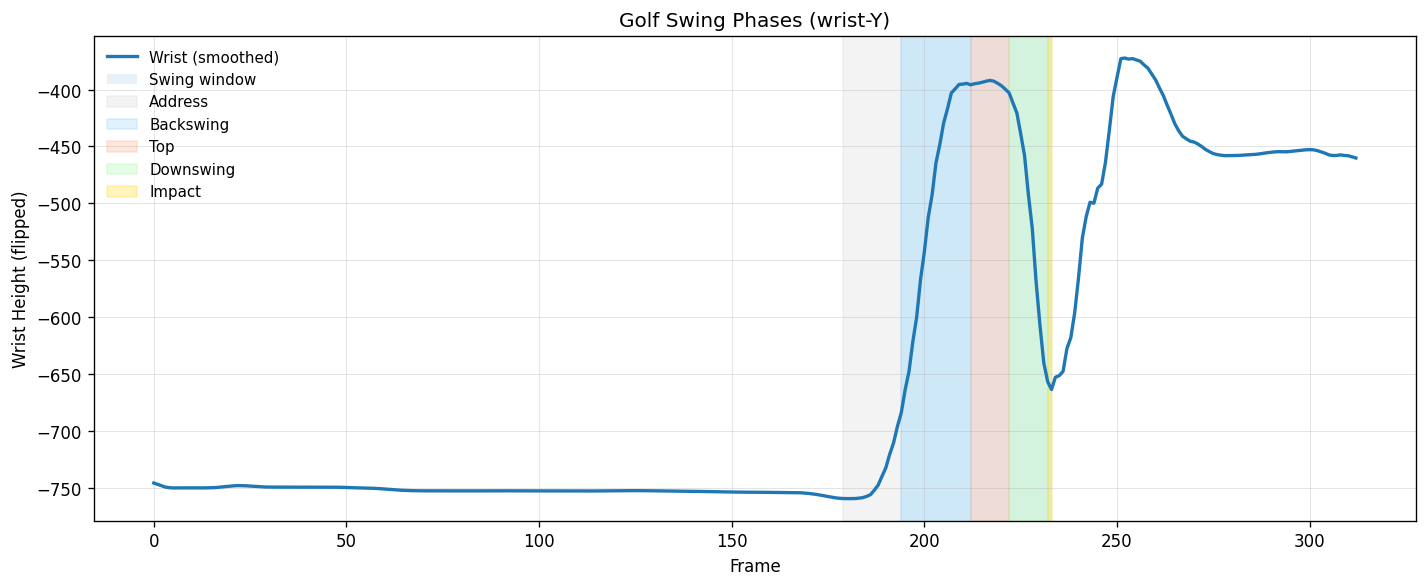

In [7]:

# === User parameters ===
VIDEO_PATH = "swing.mp4"  # Change accordingly

SMOOTHING = 5         # moving average window (odd integer >=1)
PERCENTILE = 90.0     # velocity percentile for swing start
PRECHECK = 30         # frames to ignore at the front for thresholding
VIS_THRESH = 0.4      # wrist visibility threshold (MediaPipe)

# === Run ===
frame_idxs, wrist_y, fps = extract_wrist_y(VIDEO_PATH, vis_thresh=VIS_THRESH)
results = detect_swing_phases(
    wrist_y,
    smoothing_window=int(SMOOTHING),
    precheck_window=int(PRECHECK),
    threshold_percentile=float(PERCENTILE),
)

sm = results["smoothed"]
swing_start = results["swing_start"]
swing_end = results["swing_end"]
phases = results["phase_ranges"]

print("=== Swing Summary ===")
print(f"Frames: {len(sm)} | FPS: {fps:.2f}")
print(f"Swing start: {swing_start} | Swing end: {swing_end}")
for k, (l, r) in phases.items():
    print(f"{k:16s}: {l:5d} - {r:5d} (len {r-l:4d})")

plot_phases(sm, phases, swing_start, swing_end)


In [8]:
# --- Helper: draw pose skeleton on a single frame index ---
import mediapipe as mp
import cv2
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

def draw_pose_on_frame(video_path: str, frame_idx: int,
                       model_complexity: int = 1,
                       vis_thresh: float = 0.3):
    """
    Returns (rgb_frame_with_skeleton, success_flag).
    - Seeks to frame_idx in the video
    - Runs MediaPipe Pose
    - Draws skeleton if detected
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[warn] Could not open video: {video_path}")
        return None, False

    # Seek to frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, int(frame_idx)))
    ok, frame = cap.read()
    if not ok or frame is None:
        cap.release()
        print(f"[warn] Could not read frame {frame_idx}")
        return None, False

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    with mp_pose.Pose(model_complexity=model_complexity,
                      enable_segmentation=False) as pose:
        res = pose.process(rgb)

    if res.pose_landmarks is not None:
        # Optional: drop low-visibility landmarks (kept for drawing completeness)
        annotated = rgb.copy()
        mp_drawing.draw_landmarks(
            annotated,
            res.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
        )
    else:
        annotated = rgb.copy()
        # no landmarks; still return the raw frame for context

    cap.release()
    return annotated, True


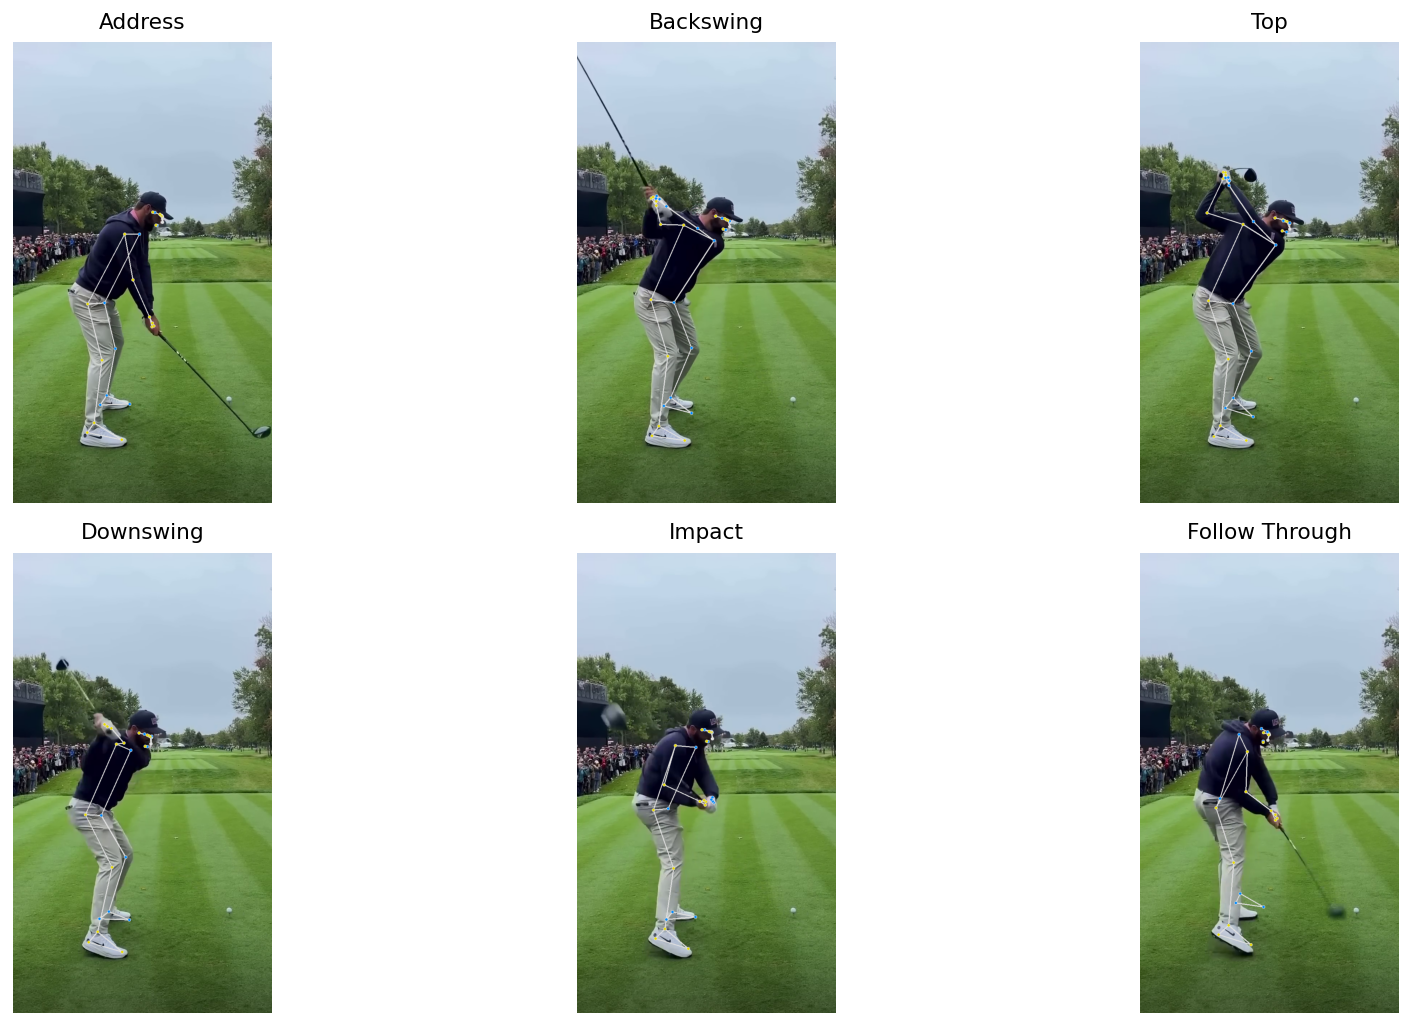

In [9]:
# --- Snapshot a representative (midpoint) frame per phase and show in a grid ---
import math
import matplotlib.pyplot as plt

# Phases to print
desired_order = [
    "Address",
    "Backswing",
    "Top",
    "Downswing",
    "Impact",
    "Follow Through",
]

# Ordered list based on what's actually present
phase_items = [(name, phases[name]) for name in desired_order if name in phases]

# Compute a representative frame (midpoint) for each phase
phase_frames = []
for name, (l, r) in phase_items:
    # Guard against degenerate ranges
    if r <= l:
        mid = l
    else:
        mid = (l + r) // 2
    phase_frames.append((name, int(mid)))

# Draw and collect images
images = []
for name, idx in phase_frames:
    img, ok = draw_pose_on_frame(VIDEO_PATH, idx)
    if not ok or img is None:
        # Create a placeholder if something goes wrong
        img = np.zeros((360, 640, 3), dtype=np.uint8)
        cv2.putText(img, "No frame / pose", (20, 180),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append((name, img))

# Plot in a 2x3 grid
cols = 3
rows = math.ceil(len(images) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 8), dpi=130)
axes = np.array(axes).reshape(rows, cols)

for i, ax in enumerate(axes.ravel()):
    ax.axis("off")
    if i < len(images):
        name, img = images[i]
        ax.imshow(img)
        ax.set_title(f"{name}", fontsize=12, pad=8)

plt.tight_layout()
plt.show()
